In [1]:
import numpy as np
import scipy.sparse as sp
import unittest
from SimPEG import Mesh, Maps, Models, Utils, PF, Regularization, Directives
from SimPEG import InvProblem, Optimization, Inversion, DataMisfit
import inspect
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



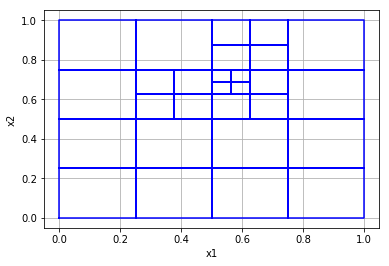

In [11]:
mesh = Mesh.TreeMesh([16,16])
mesh.refine(2)

# def refine(cell):
#     level=4
#     xyz = cell.center + mesh.x0
#     if np.all([xyz[0]>.6, xyz[0]<0.7,
#                xyz[1]>.6, xyz[1]<0.7]):
#         return level
#     return 0

def refine(cell):
    level =5
    locs = np.r_[0.6,0.7]
    bsw = cell.center - np.r_[cell.h]/2

    tne = cell.center + np.r_[cell.h]/2

#                xyz = cell.center + mesh.x0
    if np.all([bsw < locs, tne > locs]):
        return level
    return 0
        
mesh.refine(refine)
mesh.refine(refine)
mesh.plotGrid()
plt.show()



In [3]:
Fx = lambda x: 2*np.pi*np.cos(2*np.pi*x)
Fy = lambda y: 2*np.pi*np.cos(2*np.pi*y)
Fz = lambda z: 2*np.pi*np.cos(2*np.pi*z)

F = lambda xyz: np.sin(2*np.pi*xyz[:,0])+np.sin(2*np.pi*xyz[:,1])

mesh.area
# area = Utils.sdiag(1./(np.r_[mesh._areaFxFull, mesh._areaFyFull]))
# vol = Utils.sdiag(1./mesh.vol**0.5)


# Fc = cartF2(mesh, solFx, solFy)
# F = mesh.M.projectFaceVector(Fc)
dx = mesh._cellGradxStencil() * mesh.gridCC[:,0]
dy = mesh._cellGradyStencil() * mesh.gridCC[:,1]

dx[dx>0] = 1./dx[dx>0]
dy[dy>0] = 1./dy[dy>0]
print(dx.min(), dx.max(),np.median(dx))
h = Utils.sdiag((np.r_[dx, dy]))

gradV = h * mesh.cellGradStencil

BC = Utils.mkvc(np.abs(gradV).sum(1) == 0)
gradF = gradV*(F(mesh.gridCC))

gradF_ana = np.r_[Fx(mesh._gridFx[:,0]), Fy(mesh._gridFy[:,1])]
gradF_ana[BC] = 0
err = np.linalg.norm((gradF-gradF_ana), np.inf)

0.0 16.0 4.0


In [4]:
err
mesh._gridFx.shape[0]
mesh.nFx

29

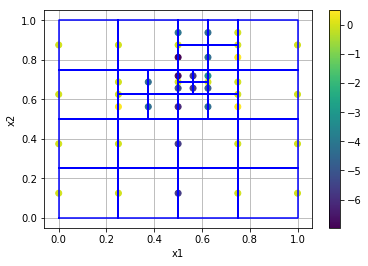

In [5]:
plt.figure()
mesh.plotGrid()
plt.scatter(mesh._gridFx[:,0],mesh._gridFx[:,1], c=gradF[:mesh._gridFx.shape[0]],vmax=0.5)
plt.colorbar()
plt.show()

In [6]:
gradF[28]

0.0

In [7]:
# p = mesh._pointer(mesh._sortedCells[13])
# w = mesh._levelWidth(p[-1])
# mesh._index(mesh._pointer(mesh._sortedCells[11]))
# mesh._cc2i[]
# cellx = mesh._getNextCell(mesh._index([p[0], p[1], p[2]]), direction=0)
# mesh._fx2i[]
# Loop through the hangings and flag the overlaping element
# faceParentx = dict()
# theHang = mesh._hangingFx
# for key in theHang.keys():
#     if not theHang[key][0][0] in faceParentx.keys():
#         faceParentx[theHang[key][0][0]] = [key]
#     else:
#         faceParentx[theHang[key][0][0]] += [key]
        
# faceParenty = dict()
# theHang = mesh._hangingFy
# for key in theHang.keys():
#     if not theHang[key][0][0] in faceParenty.keys():
#         faceParenty[theHang[key][0][0]] = [key]
#     else:
#         faceParenty[theHang[key][0][0]] += [key]
        
# faceParentz = dict()
# theHang = mesh._hangingFz
# for key in theHang.keys():
#     if not theHang[key][0][0] in faceParentz.keys():
#         faceParentz[theHang[key][0][0]] = [key]
#     else:
#         faceParentz[theHang[key][0][0]] += [key]

In [8]:
mesh.number()

# TODO: Preallocate!
I, J, V = [], [], []
PM = [-1, 1]#*mesh.dim  # plus / minus

# TODO total number of faces?
offset = [0] + [mesh.ntFx] + [mesh.ntFx+mesh.ntFy]

for ii, ind in enumerate(mesh._sortedCells):

    p = mesh._pointer(ind)
#     w = mesh._levelWidth(p[-1])
    
    if mesh.dim == 2:
        cellx = mesh._getNextCell(mesh._index([p[0], p[1], p[2]]), direction=0)
    elif mesh.dim == 3:
        cellx = mesh._getNextCell(mesh._index([p[0], p[1], p[2], p[3]]), direction=0)
    
    if cellx:
        if isinstance(cellx, int):
            cellx = [cellx]

        for cell in cellx:

            px = mesh._pointer(cell)
            
            if px[-1] < p[-1]:
                if mesh.dim == 2:
                    hangs = faceParentx[mesh._fx2i[mesh._index([px[0], px[1], px[2]])]]
                    count = int(np.abs(p[1] - px[1]) / (mesh.maxLevel-p[2]+ 1))

                elif mesh.dim == 3:
                    hangs = faceParentx[mesh._fx2i[mesh._index([px[0], px[1], px[2], px[3]])]]                    
                    count = int(np.abs(p[1] - px[1]) / (mesh.maxLevel-p[3]+ 1))
                    count += int(2*np.abs(p[2] - px[2]) / (mesh.maxLevel-p[3]+ 1))
                face = hangs[count] 
            else:
                if mesh.dim == 2:
                    face = mesh._fx2i[mesh._index([px[0], px[1], px[2]])]
                elif mesh.dim == 3:
                    face = mesh._fx2i[mesh._index([px[0], px[1], px[2], px[3]])]
                

            I += [face]*2
            J += [mesh._cc2i[ind], mesh._cc2i[cell]]
            V += PM

Gx = sp.csr_matrix((V, (I, J)), shape=(mesh.ntFx, mesh.nC))

I, J, V = [], [], []
PM = [-1, 1]#*mesh.dim  # plus / minus
for ii, ind in enumerate(mesh._sortedCells):

    p = mesh._pointer(ind)   
    celly = mesh._getNextCell(mesh._index([p[0], p[1], p[2]]), direction=1)
    if celly:
        if isinstance(celly, int):
            celly = [celly]

        for cell in celly:

            py = mesh._pointer(cell)
            
            if py[-1] < p[-1]:
                hangs = faceParenty[mesh._fy2i[mesh._index([py[0], py[1], py[2]])]]
                count = int((p[1] - py[1]) / (mesh.maxLevel-p[2]+ 1))
                face = hangs[count] 
            else:
                face = mesh._fy2i[mesh._index([py[0], py[1], py[2]])]
            I += [face]*2
            J += [mesh._cc2i[ind], mesh._cc2i[cell]]
            V += PM
    

Gy = sp.csr_matrix((V, (I, J)), shape=(mesh.ntFy, mesh.nC))


I, J, V = [], [], []
PM = [0.5, 0.5]#*mesh.dim  # plus / minus

for ii, ind in enumerate(mesh._sortedCells):

    p = mesh._pointer(ind)
#     w = mesh._levelWidth(p[-1])
    
    cellx = mesh._getNextCell(mesh._index([p[0], p[1], p[2]]), direction=0)
    
    if cellx:
        if isinstance(cellx, int):
            cellx = [cellx]

        for cell in cellx:

            px = mesh._pointer(cell)
            
            if px[-1] < p[-1]:
                hangs = faceParentx[mesh._fx2i[mesh._index([px[0], px[1], px[2]])]]
                count = int((px[1] - p[1]) / (mesh.maxLevel-p[2]+ 1))
                
                face = hangs[count] 
            else:
                face = mesh._fx2i[mesh._index([px[0], px[1], px[2]])]

            I += [face]*2
            J += [mesh._cc2i[ind], mesh._cc2i[cell]]
            V += PM

aveCC2Fx = sp.csr_matrix((V, (I, J)), shape=(mesh.ntFx, mesh.nC))
aveCC2Fx = aveCC2Fx * Utils.sdiag(1./aveCC2Fx.sum(0))
# R = mesh._deflationMatrix('Fx', large=True)
# Sx = sp.hstack([sp.identity(mesh.ntFx),
#                            sp.csr_matrix((mesh.ntFx, mesh.ntFy))])
# Sy = sp.hstack([sp.csr_matrix((mesh.ntFy, mesh.ntFx)),
#                            sp.identity(mesh.ntFy)])
# Gx = ((D*R).T)

# bc = Utils.mkvc(Gx.sum(1) == 0)
# Gx=Sx * G
# Gy=Sy * G
# Gx_hang = []
# for ii in range(Gx.shape[0]):
#     if Gx[ii,:].count_nonzero() > 2:
#         row = Gx[ii,:].copy()
        
#         ind = np.where(row.todense()!=0)[1]
        
#         # The largest absolute value is the cell
#         ind1 = np.argmax(np.abs(row))
#         ind = ind[ind!=ind1]
        
        
#         for jj in range(len(ind)):
            
#             if jj == 0:
#                 Gx[ii,ind1] = np.sign(row[0,ind1])*1
#                 Gx[ii,ind] = 0
#                 Gx[ii,ind[jj]] = np.sign(row[0,ind[jj]])*1

#             else:
#                 temp = row.copy()
#                 temp[0,ind1] = np.sign(row[0,ind1])*1
#                 temp[0,ind] = 0
#                 temp[0,ind[jj]] = np.sign(row[0,ind[jj]])*1
        
#                 Gx_hang += [temp]
        
# Gx = sp.vstack([Gx,sp.vstack(Gx_hang)])
# scale = Utils.mkvc(np.abs(Gx).max(1).todense())
# scale[scale>1] /= 2
# Gx = Utils.sdiag(1./scale) * Gx  
# Gx[np.abs(Gx) ==0.5] *= 2
# V = np.ones((bc == 0).sum())
# I = range((bc == 0).sum())
# J = np.where(bc==0)[0]
# S = sp.csr_matrix((V, (I, J)), shape=((bc == 0).sum(), Gx.shape[0]))
# Gx = S * Gx 
# VOL = mesh.vol
# if mesh.dim == 2:
#     S = np.r_[mesh._areaFxFull, mesh._areaFyFull]
# elif mesh.dim == 3:
#     S = np.r_[mesh._areaFxFull, mesh._areaFyFull, mesh._areaFzFull]
# mesh._cellGradStencil = (D*R).T

NameError: name 'faceParentx' is not defined

In [14]:
mesh.maxLevel
Gx=mesh._cellGradxStencil()
Gy=mesh._cellGradyStencil()
# Gz =mesh._cellGradzStencil()

avx = mesh.aveCC2Fx()
avy = mesh.aveCC2Fy()
# avz = mesh.aveCC2Fz()


In [19]:

# G = mesh._cellGradxStencil()
# ind = np.sign(G.sum(0))

# ind = G.sum(1) < -1.5
# G[ind,>1]=G[np.abs(G)>1]/1.5
# aveFx2CC = mesh.aveFx2CC
# aveCC2Fx = Utils.sdiag(1./(mesh.aveFx2CC.T).sum(1)) * mesh.aveFx2CC.T
def f(ind):
    vx = np.zeros(Gx.shape[1])
    vx[ind] = 1
    
    vy = np.zeros(Gy.shape[1])
    vy[ind] = 1
    
    ggx = Gx.T*Gx*vx
    ggy = Gy.T*Gy*vy
#     ggz = Gz.T*Gz*vy
#     print(np.unique(avg))
#     avg = mesh._cellGradxStencil().T*mesh._cellGradxStencil() * vec
#     print(mesh.nC,avg.shape)
    ax1 = plt.subplot(1,3,1)
    mesh.plotSlice(ggx, clim=[-2,2],grid=True, ax=ax1)
    
    ax2 = plt.subplot(1,3,2)
    mesh.plotSlice(ggy, clim=[-2,2],grid=True, ax= ax2)
    
#     ax3 = plt.subplot(1,3,3)
#     mesh.plotSlice(ggz, clim=[-2,2],grid=True, ax= ax3,normal='Y', ind=10)
    
    plt.show()

interactive_plot = interactive(f, ind=(0, mesh.nC))

interactive_plot

In [ ]:
avx[:,72].max()

In [ ]:
Mesh.TreeMesh.readUBC()